In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
%matplotlib inline

print(tf.test.is_built_with_cuda())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print(tf.test.is_gpu_available())

2024-04-20 16:48:59.594961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 16:48:59.790987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 16:48:59.792047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 16:49:00.564594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rgferrari/miniconda3/envs/dimensionality-reduction/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a plann

True
Num GPUs: 0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


2024-04-20 16:49:01.898735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 16:49:02.055328: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-04-20 16:49:02.058891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-20 16:49:02.058933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make

## Setup Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
x_train = tf.image.convert_image_dtype(x_train, dtype=tf.float32)
x_test = tf.image.convert_image_dtype(x_test, dtype=tf.float32)

<Axes: ylabel='Count'>

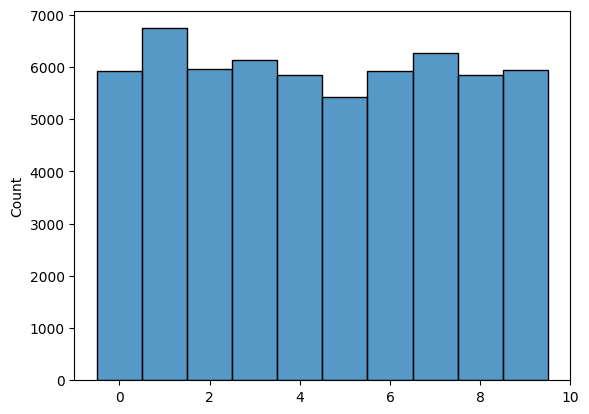

In [4]:
sns.histplot(y_train, discrete=True)

<Axes: ylabel='Count'>

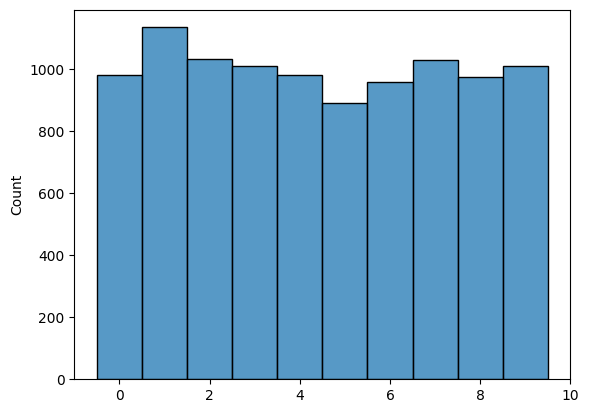

In [5]:
sns.histplot(y_test, discrete=True)

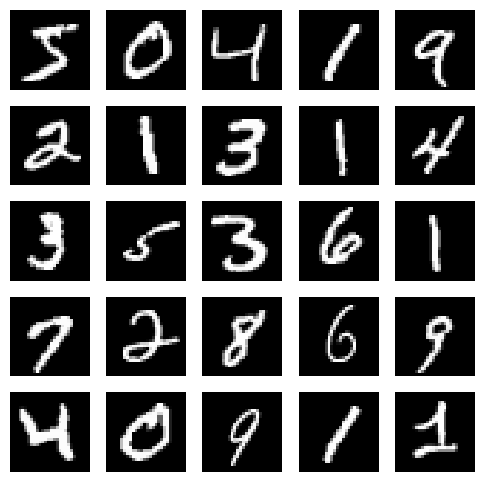

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(6, 6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray', interpolation='none')
    ax.axis('off') 

plt.show()

## Setup Encoder

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,                        
    patience=2
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=4,
    verbose=1,
    restore_best_weights=True,
)

In [8]:
def build_encoder():
    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

    ])
    
    encoder.compile(
        optimizer=tf.keras.optimizers.Adam(1e-2),
        loss=tfa.losses.TripletHardLoss())

    return encoder

In [9]:
encoder = build_encoder()

print(encoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0

In [10]:
history = encoder.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100


2024-04-20 16:49:03.483798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'y_pred' with dtype float and shape [?,256]
	 [[{{node y_pred}}]]
2024-04-20 16:49:03.569058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/Max_1_grad/Sum/Max_1/reduction_indices' with dtype int32
	 [[{{node gradients/Max_1_grad/Sum/Max_1/reduction_indices}}]]
2024-04-20 16:49:03.572151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/Min_g

1688/1688 [==============================] - 17s 9ms/step - loss: 0.9042 - val_loss: 0.4983 - lr: 0.0100
Epoch 2/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6973 - val_loss: 0.4200 - lr: 0.0100
Epoch 3/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6558 - val_loss: 0.4023 - lr: 0.0100
Epoch 4/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6357 - val_loss: 0.3881 - lr: 0.0100
Epoch 5/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6215 - val_loss: 0.3742 - lr: 0.0100
Epoch 6/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6133 - val_loss: 0.3694 - lr: 0.0100
Epoch 7/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6029 - val_loss: 0.3682 - lr: 0.0100
Epoch 8/100
1688/1688 [==============================] - 16s 9ms/step - loss: 0.6001 - val_loss: 0.3577 - lr: 0.0100
Epoch 9/100
1688/1688 [==============================] - 15s 9ms/step - loss

In [11]:
encoder.save('embedding-clustering-encoder.keras')

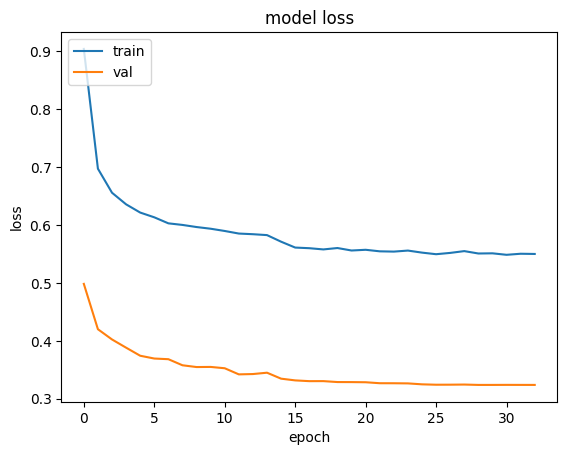

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [13]:
encoder = tf.keras.models.load_model('embedding-clustering-encoder.keras')

In [14]:
def euclidian_dist(A, B):
    return (tf.expand_dims(A, 1) - tf.expand_dims(B, 0))**2

def get_masks(labels):
    mask_ap = tf.expand_dims(labels, 1) == tf.expand_dims(labels, 0)
    mask_an = tf.math.logical_not(mask_ap)
    
    return mask_ap, mask_an

def evaluate_n2n(embeddings, labels):    
    distances = tf.reduce_sum(euclidian_dist(embeddings, embeddings), 2) 
    mask_ap, mask_an = get_masks(labels)
    distances_ap = distances * tf.cast(mask_ap, tf.float32)
    distances_an = distances * tf.cast(mask_an, tf.float32)

    return distances

In [15]:
# Confusion Matrix here

In [16]:
embeddings_test = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [17]:
distances = evaluate_n2n(embeddings_test[:1000], y_test[:1000])

## Visualizing 2D

In [18]:
tsne_2d = TSNE(n_components=2, random_state=42)
reduced_data_2d = tsne_2d.fit_transform(embeddings_test)
print(reduced_data_2d.shape)

(10000, 2)


/tmp/ipykernel_730/1852009169.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', num_labels)


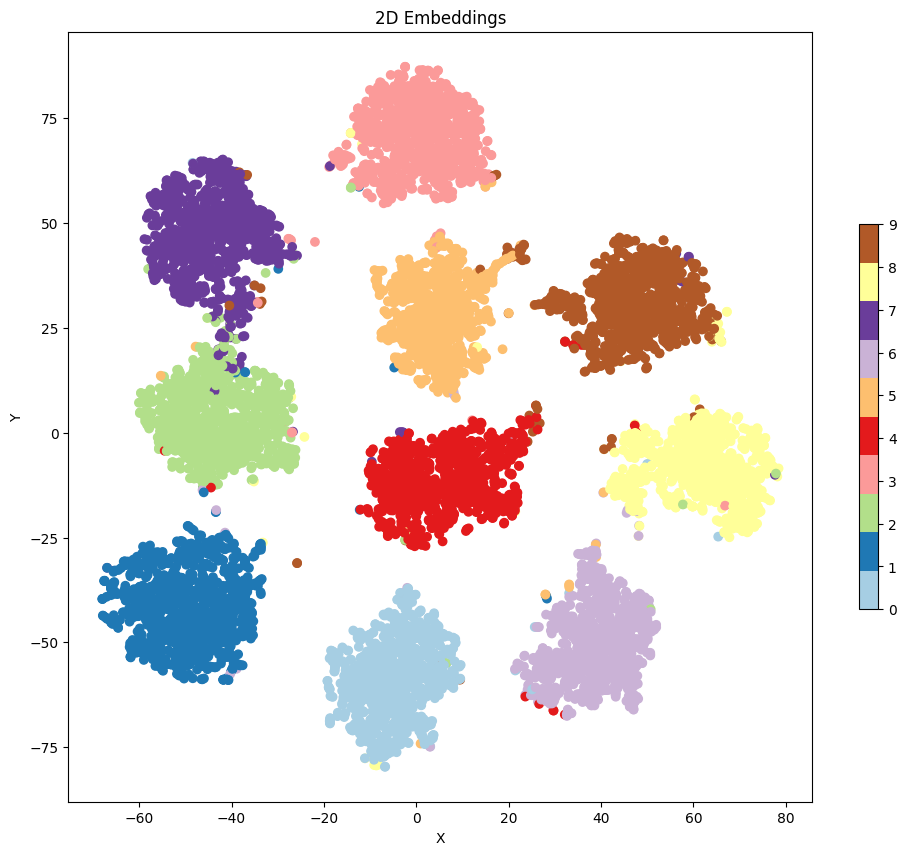

In [19]:
num_labels = len(np.unique(y_test))
cmap = plt.cm.get_cmap('Paired', num_labels)
color_list = [cmap(i) for i in range(num_labels)]
custom_cmap = ListedColormap(color_list)

fig = plt.figure(figsize=(12, 10))
scatter = plt.scatter(reduced_data_2d[:, 0], reduced_data_2d[:, 1], c=y_test, cmap=custom_cmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Embeddings')

subtitles = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

cbar = plt.colorbar(scatter, ticks=np.arange(num_labels), shrink=0.5)
cbar.ax.set_yticklabels([subtitles[label] for label in range(num_labels)])

plt.show()

## Visualizing 3D

In [20]:
tsne_3d = TSNE(n_components=3, random_state=42)
reduced_data_3d = tsne_3d.fit_transform(embeddings_test)
print(reduced_data_3d.shape)

(10000, 3)


/tmp/ipykernel_730/467688637.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', num_labels)


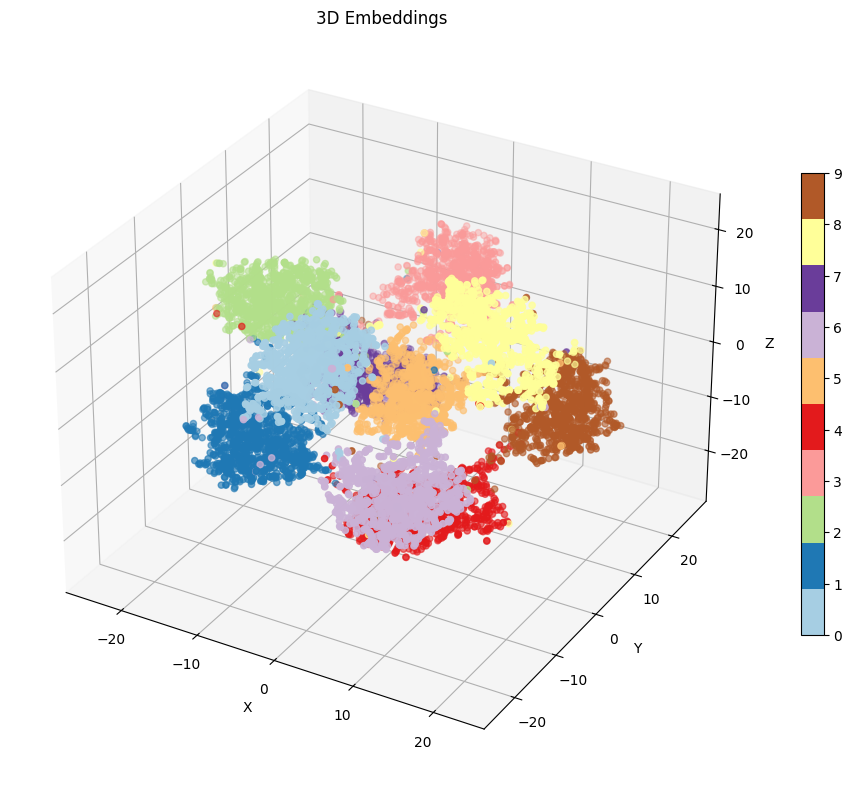

In [21]:
num_labels = len(np.unique(y_test))
cmap = plt.cm.get_cmap('Paired', num_labels)
color_list = [cmap(i) for i in range(num_labels)]
custom_cmap = ListedColormap(color_list)

subtitles = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9'
}

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2], c=y_test, cmap=custom_cmap)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Embeddings')

cbar = plt.colorbar(scatter, ticks=np.arange(num_labels), shrink=0.5)
cbar.ax.set_yticklabels([subtitles[label] for label in range(num_labels)])

plt.show()

## Setup Decoder

In [22]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,                        
    patience=2
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True,
)

In [23]:
def build_decoder():
    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*32, activation='relu', input_shape=(256,)),  # Reverse of the Flatten layer in the encoder
        tf.keras.layers.Reshape((7, 7, 32)),  # Reshape to match the shape after the MaxPooling2D layer in the encoder
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, padding='same', activation='relu'),  # Reverse of the Conv2D layer in the encoder
        tf.keras.layers.UpSampling2D(size=2),  # Reverse of the MaxPooling2D layer in the encoder
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, padding='same', activation='relu'),  # Reverse of the Conv2D layer in the encoder
        tf.keras.layers.UpSampling2D(size=2),  # Reverse of the MaxPooling2D layer in the encoder
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, padding='same', activation='sigmoid')  # Output layer, using sigmoid activation for pixel values between 0 and 1
    ])
    
    decoder.compile(
        optimizer=tf.keras.optimizers.Adam(1e-2),
        loss='mean_squared_error')

    return decoder

In [24]:
decoder = build_decoder()

print(decoder.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1568)              402976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 32)         4128      
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       8256      
 ranspose)                                                       
                                                      

In [25]:
embeddings_train = encoder.predict(x_train)

1875/1875 [==============================] - 3s 2ms/step


In [26]:
history = decoder.fit(
    x=embeddings_train,
    y=x_train,
    batch_size=64,
    epochs=100,
    shuffle=True,
    validation_split=0.1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
844/844 [==============================] - 16s 19ms/step - loss: 0.0523 - val_loss: 0.0482 - lr: 0.0100
Epoch 2/100
844/844 [==============================] - 17s 21ms/step - loss: 0.0490 - val_loss: 0.0473 - lr: 0.0100
Epoch 3/100
844/844 [==============================] - 16s 19ms/step - loss: 0.0483 - val_loss: 0.0469 - lr: 0.0100
Epoch 4/100
844/844 [==============================] - 14s 17ms/step - loss: 0.0478 - val_loss: 0.0467 - lr: 0.0100
Epoch 5/100
844/844 [==============================] - 13s 16ms/step - loss: 0.0475 - val_loss: 0.0465 - lr: 0.0100
Epoch 6/100
844/844 [==============================] - 13s 15ms/step - loss: 0.0472 - val_loss: 0.0464 - lr: 0.0100
Epoch 7/100
844/844 [==============================] - 16s 19ms/step - loss: 0.0471 - val_loss: 0.0460 - lr: 0.0100
Epoch 8/100
844/844 [==============================] - 16s 19ms/step - loss: 0.0469 - val_loss: 0.0460 - lr: 0.0100
Epoch 9/100
844/844 [==============================] - 16s 19ms/step - l

In [27]:
decoder.save('embedding-clustering-decoder.keras')

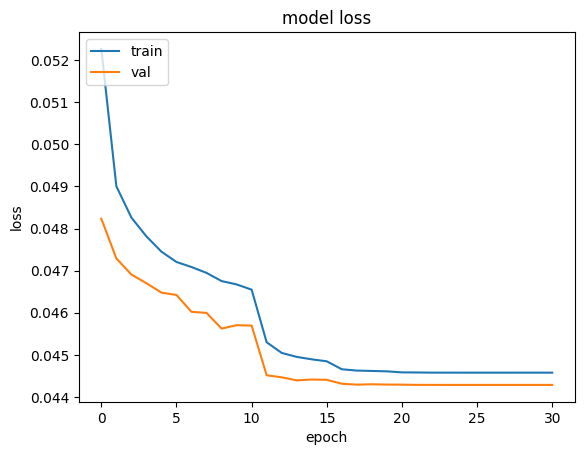

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
decoded_test = decoder(encoder(x_test))
print(decoded_test.shape)

2024-04-20 17:05:55.483826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2007040000 exceeds 10% of free system memory.
2024-04-20 17:05:55.749815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2007040000 exceeds 10% of free system memory.
2024-04-20 17:05:56.080159: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2007040000 exceeds 10% of free system memory.
2024-04-20 17:05:57.263656: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2007040000 exceeds 10% of free system memory.


(10000, 28, 28, 1)


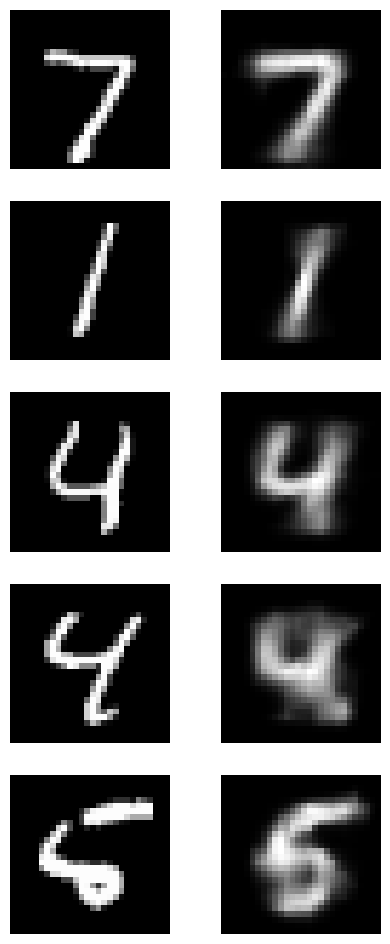

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5,12))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i % 2 == 0:
        ax.imshow(x_test[i], cmap='gray', interpolation='none')
    else:
        ax.imshow(decoded_test[i-1], cmap='gray', interpolation='none')
    ax.axis('off') 

plt.show()